In [453]:
from torch import nn
import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.categorical import Categorical

In [454]:
import matplotlib.pyplot as plt

In [455]:
c = [MultivariateNormal(torch.tensor([-5.0, 5.0]), torch.eye(2)*0.01**2),
    MultivariateNormal(torch.tensor([5.0, 5.0]), torch.eye(2)*0.01**2),
    MultivariateNormal(torch.tensor([5.0, -5.0]), torch.eye(2)*0.01**2),
    MultivariateNormal(torch.tensor([-5.0, -5.0]), torch.eye(2)*0.01**2)]

pi = torch.tensor([0.25, 0.25, 0.25, 0.25])

def logtarget(x):
    assert x.shape[1] == 2
    logProbaComponent = torch.stack([c[i].log_prob(x) + pi[i].log() for i in range(len(c))])
    return torch.logsumexp(logProbaComponent, 0)

In [456]:
log_prob_func = logtarget

In [457]:
def leapfrog(params, momentum, log_prob_func, temperature, steps=10, step_size=0.1):
    def params_grad(p):
        p = p.detach().requires_grad_()
        global_log_prob = (log_prob_func(params)/temperature).sum()
        return torch.autograd.grad(global_log_prob, params)[0]

    momentum += 0.5 * step_size * params_grad(params)
    for n in range(steps):
        params = params + step_size * momentum
        p_grad = params_grad(params)
        momentum += step_size * p_grad
    momentum -= 0.5 * step_size * p_grad.clone()
    return params, momentum

In [458]:
def sample(log_prob_func, params_init, num_samples=10, num_steps_per_sample=10, step_size=0.1, burn=0):

    params = params_init.clone().requires_grad_()
    ret_params = [params.clone()]
    num_rejected = 0
    
    for n in range(num_samples):
        momentum = gibbs(params)

        ham = hamiltonian(params, momentum, log_prob_func, temperature)

        leapfrog_params, leapfrog_momenta = leapfrog(params, momentum, log_prob_func, steps=num_steps_per_sample, step_size=step_size)

        params = leapfrog_params[-1].detach().requires_grad_()
        momentum = leapfrog_momenta[-1]
        new_ham = hamiltonian(params, momentum, log_prob_func, temperature)

        rho = min(0., acceptance(ham, new_ham))
        
        if rho >= torch.log(torch.rand(1)):
            if n > burn:
                ret_params.extend(leapfrog_params)
        else:
            num_rejected += 1
            params = ret_params[-1]
            if n > burn:
                leapfrog_params = ret_params[-num_steps_per_sample:] ### Might want to remove grad as wastes memory
                ret_params.extend(leapfrog_params) # append the current sample to the chain

    return list(map(lambda t: t.detach(), ret_params))

In [459]:
def gibbs(params):
    dist = torch.distributions.Normal(torch.zeros_like(params), torch.ones_like(params))    
    return dist.sample()

In [460]:
def hamiltonian(params, momentum, log_prob_func, temperature):
    log_prob = log_prob_func(params)
    potential = -log_prob/temperature
    kinetic = 0.5 * (momentum**2).sum(dim=1)
    hamiltonian = potential + kinetic
    return hamiltonian

In [461]:
nb_chain = 50
nb_iter = 5000
nb_inner = 5

nb_leapfrog = 25
step_size = .01

temperature = torch.linspace(torch.tensor(1.0).log(), torch.tensor(100000.0).log(), nb_chain).exp()

state = torch.rand((nb_chain,2))*0.00000001
acceptance = torch.zeros(nb_chain)
swapCount = torch.zeros((nb_chain,))
history = torch.zeros((nb_iter, nb_chain, 2))
history[0] = state

In [462]:
for t in range(1, nb_iter):
    state = state.detach().clone()
    params = state.detach().clone().requires_grad_()
    
    momentum = gibbs(params)
    ham = hamiltonian(params, momentum, log_prob_func, temperature)

    leapfrog_params, leapfrog_momenta = leapfrog(params, momentum, log_prob_func, temperature, steps=nb_leapfrog, step_size=step_size)

    params = leapfrog_params.detach().clone().requires_grad_()
    momentum = leapfrog_momenta
    new_ham = hamiltonian(params, momentum, log_prob_func, temperature)

    rho = -new_ham/temperature + ham/temperature
    accept = torch.rand(ham.shape).log() < rho
    
    state[accept,:] = params[accept,:]
    history[t] = state.detach().clone()
    
    acceptance += accept*1.0
    
    # SWAP PHASE
    if t % nb_inner == 0:
        logProba = logtarget(state)
        for j in np.random.permutation(nb_chain-1):
            T_left = temperature[j]
            T_right = temperature[j+1]
            LP_left = logProba[j]
            LP_right = logProba[j+1]

            logA = LP_left/T_right + LP_right/T_left \
                 - LP_left/T_left - LP_right/T_right

            R = torch.exp(logA).cpu()

            if torch.rand(1)[0] < R:
                tmp = state[j,:].detach().clone() 
                state[j,:] = state[j+1,:].detach().clone() 
                state[j+1,:] = tmp

                tmp = logProba[j].detach().clone() 
                logProba[j] = logProba[j+1].detach().clone() 
                logProba[j+1] = tmp

                swapCount[j] += 1

In [463]:
acceptance/t

tensor([0.8774, 0.9282, 0.9350, 0.9660, 0.9874, 0.9782, 0.9882, 0.9842, 0.9884,
        0.9910, 0.9898, 0.9894, 0.9930, 0.9990, 0.9996, 0.9996, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [464]:
swapCount

tensor([875., 869., 898., 871., 880., 883., 901., 866., 886., 890., 901., 866.,
        883., 886., 888., 872., 869., 897., 904., 882., 891., 885., 871., 872.,
        871., 881., 868., 883., 882., 885., 863., 885., 876., 872., 865., 900.,
        870., 878., 881., 876., 869., 871., 896., 891., 877., 893., 908., 919.,
        913.,   0.])

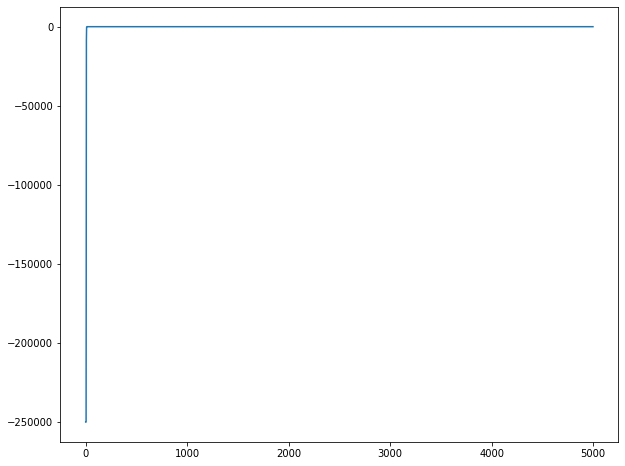

In [465]:
fig = plt.figure(figsize=(10,8))
plt.plot(logtarget(history[:,0,:]).detach().clone().cpu().numpy())

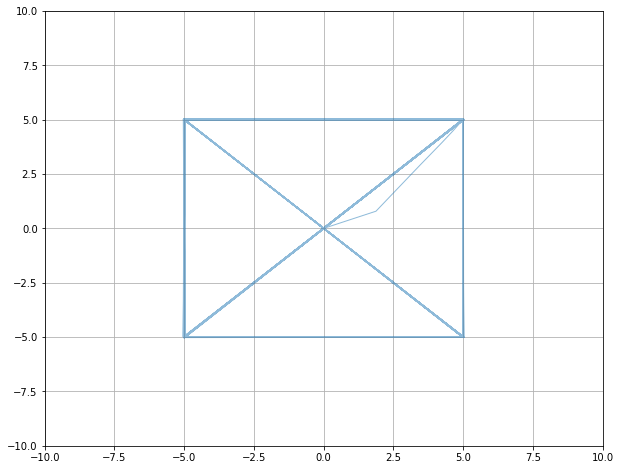

In [466]:
fig = plt.figure(figsize=(10,8))
chain = 0
plt.plot(history[:,chain,0].detach().clone().cpu().numpy(),
         history[:,chain,1].detach().clone().cpu().numpy(), 
         linewidth=1, 
         alpha=0.5)
plt.axis([-10, 10, -10, 10])
plt.grid()

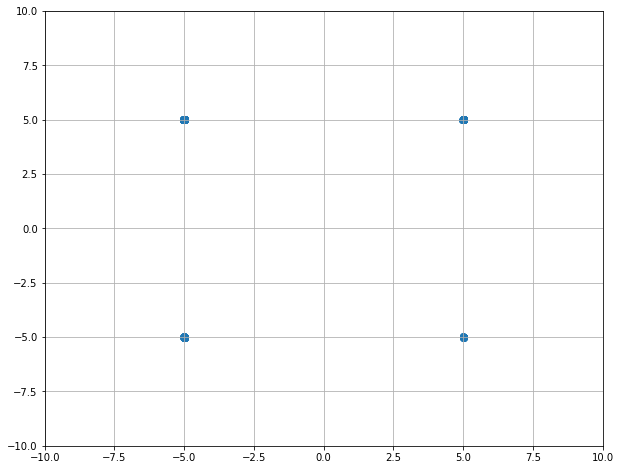

In [467]:
fig = plt.figure(figsize=(10,8))
chain = 0
plt.scatter(history[100:,chain,0].detach().clone().cpu().numpy(),
            history[100:,chain,1].detach().clone().cpu().numpy())
plt.axis([-10, 10, -10, 10])
plt.grid()

In [468]:
history

tensor([[[ 8.6581e-09,  2.4373e-09],
         [ 5.6379e-09,  3.4321e-09],
         [ 4.4070e-09,  7.1619e-09],
         ...,
         [ 8.2999e-10,  4.9855e-09],
         [ 3.8464e-09,  3.4494e-09],
         [ 3.6466e-09,  9.3999e-09]],

        [[ 8.6581e-09,  2.4373e-09],
         [ 5.6379e-09,  3.4321e-09],
         [ 4.4070e-09,  7.1619e-09],
         ...,
         [ 2.7103e-01, -6.4470e-01],
         [ 4.0814e-01, -9.6183e-02],
         [ 1.9588e-01,  4.5230e-01]],

        [[ 8.6581e-09,  2.4373e-09],
         [ 5.6379e-09,  3.4321e-09],
         [ 4.4070e-09,  7.1619e-09],
         ...,
         [ 2.2930e-01, -6.1255e-01],
         [ 2.3669e-01,  1.7952e-01],
         [-3.3434e-01,  7.2733e-01]],

        ...,

        [[-5.0201e+00,  5.0063e+00],
         [-4.9849e+00, -4.9853e+00],
         [-4.9958e+00, -4.9815e+00],
         ...,
         [-5.3365e+00,  4.9210e+00],
         [-5.0029e+00,  6.2967e+00],
         [ 6.4240e+00, -3.1314e+00]],

        [[-5.0041e+00,  5.0085e+00